In [51]:
%matplotlib inline
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

conn = psycopg2.connect('dbname=info1903 user=lyneca')
cur = conn.cursor()

Using matplotlib backend: TkAgg


## Storing the dataset nicely

In [22]:
class Crash:                                          
    def __init__(self, i, c, f, b, h, a, s, r, d):
        self.id = i
        self.crashtype = c
        self.fatalities = f
        self.bus = b
        self.heavytruck = h
        self.articulatedtruck = a
        self.speedlimit = s
        self.rainfall = r
        self.date = d
        self.fdate = self.date.isoformat()

    def __repr__(self):
        return f"{self.fdate}: {self.crashtype} crash with {self.fatalities} fatalities and {self.rainfall}ml rainfall"
query = """
select *                               
  from crashes, rainfall                                                
 where rainfall.year = crashes.year                                      
   and rainfall.month = extract(MONTH from to_date(concat(crashes.month, ' 2000'), 'Month YYYY'))                                                
   and rainfall.day = crashes.day
   and crashes.state = 'VIC';
"""
cur.execute(query)
res = cur.fetchall()
cp = [Crash(x[0],x[7],x[8],x[9],x[10],x[11],x[12],x[18],datetime.datetime(year=x[15],month=x[16],day=x[17],hour=(x[5] if x[5] >= 0 else 0),minute=(x[6] if x[6] >= 0 else 0))) for x in res]
cp.sort(key=lambda x: x.fdate)
dtindex = pd.DatetimeIndex([x.fdate for x in cp])
df = pd.DataFrame([(x.fatalities,x.rainfall) for x in cp],index=dtindex,columns=['fatalities','rainfall'])
df[:10]

,fatalities,rainfall
1989-01-01 01:15:00,1,0.0
1989-01-02 19:05:00,1,0.0
1989-01-03 15:40:00,1,0.0
1989-01-03 19:55:00,1,0.0
1989-01-04 09:40:00,1,25.0
1989-01-04 12:40:00,1,25.0
1989-01-05 10:45:00,1,11.6
1989-01-05 14:08:00,5,11.6
1989-01-06 10:20:00,1,0.0
1989-01-07 06:00:00,1,0.0


## Generating the fatality/rainfall graph

[1, 2, 3, 4, 5, 6, 20, 35]
(0, 6)
[1, 2, 3, 4, 5, 6, 7, 10, 11]
(0, 7)
[1, 2, 3, 4, 5, 6]
(0, 6)
[1, 2, 3, 4, 5, 6, 11, 12]
(0, 6)
[1, 2, 3, 4, 5, 6]
(0, 6)
[1, 2, 3, 4, 5, 6, 7]
(0, 7)
[1, 2, 3, 4, 5, 6, 7]
(0, 7)


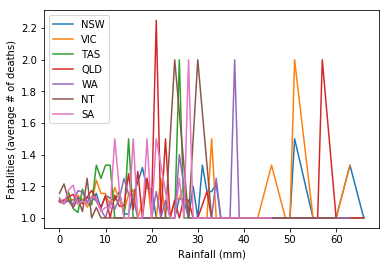

In [24]:
%matplotlib inline
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
conn = psycopg2.connect('dbname=info1903 user=lyneca')
cur = conn.cursor()

query = """
select rainfall, fatalities, rainfall.month, rainfall.year, rainfall.day                            
  from crashes, rainfall                                                
 where rainfall.year = crashes.year                                      
   and rainfall.month = extract(MONTH from to_date(concat(crashes.month, ' 2000'), 'Month YYYY'))                                                
   and rainfall.day = crashes.day
   and rainfall.rainfall is not null
   and crashes.fatalities is not null
   and crashes.state = 'STATE';
   """
states = [
    'NSW',
    'VIC',
    'TAS',
    'QLD',
    'WA',
    'NT',
    'SA'
]
queries = {x: query.replace("STATE", x) for x in states}

for q in queries:
    conn.rollback()
    cur.execute(queries[q])
    data = cur.fetchall()
    rounding = 1
    print(sorted(list({x[1] for x in data})))
    data = sorted([(round(x[0]/rounding)*rounding, x[1]) for x in data if (x[0] < 115 and x[1] < 10)], key=lambda x: (x[0],x[1]))
    rainfall = sorted(list({x[0] for x in data}))
    fatalities = []
    print(max(data,key=lambda x: x[1]))
    for r in rainfall:
        temp = 0
        for d in data:
            if d[0] == r:
                if d[1] is not None:
                    temp += d[1]
        fatalities.append(temp / [x[0] for x in data].count(r))
    
    plt.plot(rainfall, fatalities, label=q)
plt.xlabel("Rainfall (mm)")
plt.ylabel("Fatalities (average # of deaths)")
plt.legend()

Processing VIC... done.
Processing rain graph... done.


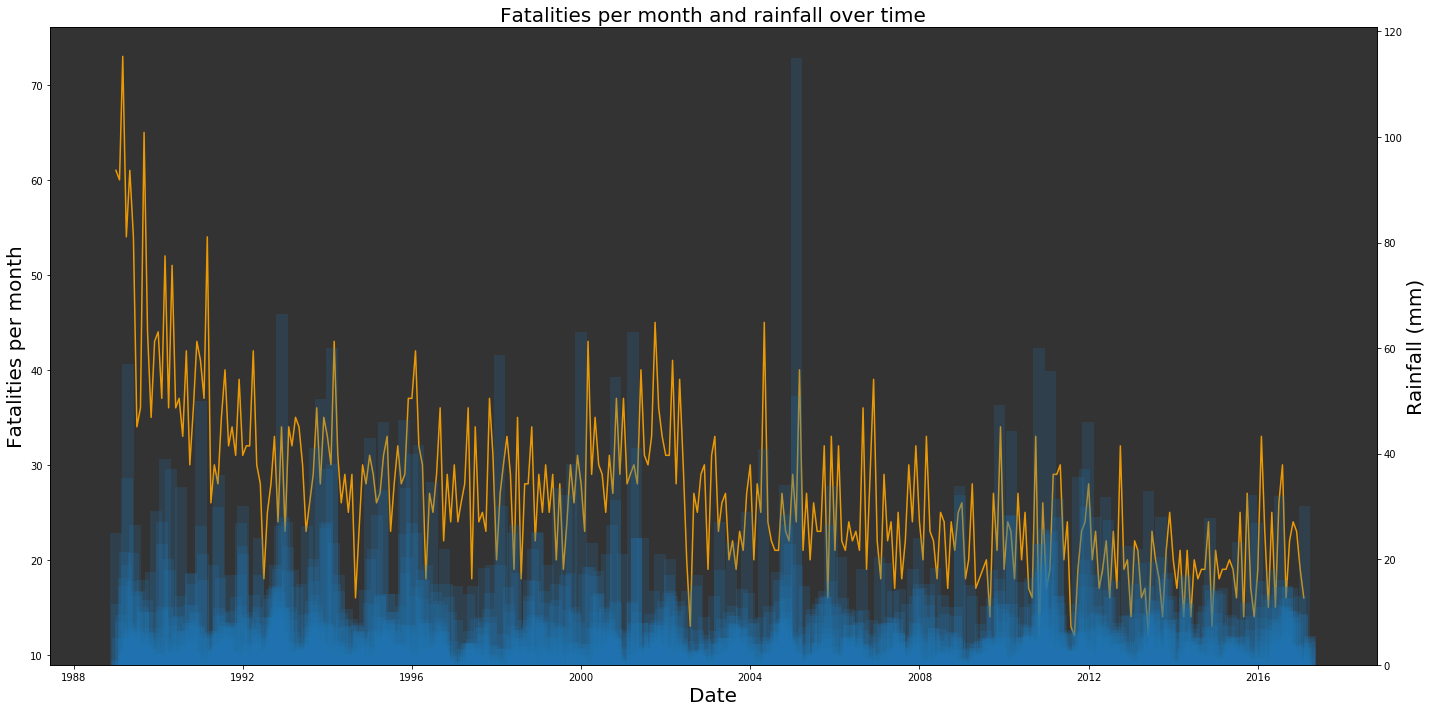

In [4]:
%matplotlib inline
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
from functools import lru_cache


conn = psycopg2.connect('dbname=info1903 user=lyneca')
cur = conn.cursor()

query = """
select rainfall, fatalities, rainfall.year, rainfall.month, rainfall.day                            
  from crashes, rainfall                                                
 where rainfall.year = crashes.year                                      
   and rainfall.month = extract(MONTH from to_date(concat(crashes.month, ' 2000'), 'Month YYYY'))                                                
   and rainfall.day = crashes.day
   and rainfall.rainfall is not null
   and crashes.fatalities is not null
   and crashes.state = 'STATE';
   """
states = [
#     'NSW',
    'VIC',
#     'QLD',
#     'WA',
#     'NT',
#     'SA',
#     'TAS',
]

fig, ax = plt.subplots(figsize=(20, 10))
c = 0.2
ax.set_facecolor((c, c, c, 1))
fig.set_facecolor((1, 1, 1, 1))
queries = {x: query.replace("STATE", x) for x in states}
colors = iter('rgbcmyk')

plt.title("Fatalities per month and rainfall over time",fontsize=20)
max_year = 2017
min_year = 1989

cur.execute(f"select rainfall, year, month, day from rainfall where year >= {min_year} and year <= {max_year} order by year, month, day;")
r_data = cur.fetchall()
r_rainfall = [(0 if x[0] is None else x[0]) for x in r_data]
r_dates = [datetime.datetime(x[1], x[2], x[3]) for x in r_data]

@lru_cache(maxsize=32)
def graph(q):
    conn.rollback()
    cur.execute(queries[q])
    data = cur.fetchall()
    rounding = 1
    data = [(x[0], x[1], datetime.datetime(x[2],x[3], 1)) for x in data if (x[0] < 115 and x[1] < 10)]
#     rainfall = [x[0] for x in data]
    dates = sorted(list({x[2] for x in data}))
    fatalities = [x[1] for x in data]
    crashes = []
    rainfall = []
    for month in dates:
        crashes.append(len([x[1] for x in data if x[2] == month]))
        rainfall.append(sum([x[0] for x in data if x[2] == month]))
    return dates, crashes, rainfall

plt.xlabel("Date", fontsize=20)

for q in queries:
    print(f"Processing {q}... ", end='')
    dates, crashes, rainfall = graph(q)
#     ax.scatter(dates, crashes, c=rainfall, label=q, alpha=0.9, s=10, cmap=plt.cm.get_cmap('Blues'))
    ax.set_ylabel("Fatalities per month", fontsize=20)
    ax.set_xlabel("Date", fontsize=20)
    ax.plot(dates, crashes, label=q, alpha=0.9, c='orange')
#     ax.bar(dates, crashes, width=10, label=q)
    ax.xaxis_date()
    print(f"done.")
print("Processing rain graph... ", end='')
ax2 = ax.twinx()
ax2.set_ylabel("Rainfall (mm)", fontsize=20)
ax2.bar(r_dates, r_rainfall, width=100, alpha=0.2, label='rainfall')
print("done.")
fig.tight_layout()
# plt.ylabel("Fatalities per month", fontsize=20)

Processing NSW...
Done NSW.
Processing VIC...
Done VIC.
Processing QLD...
Done QLD.


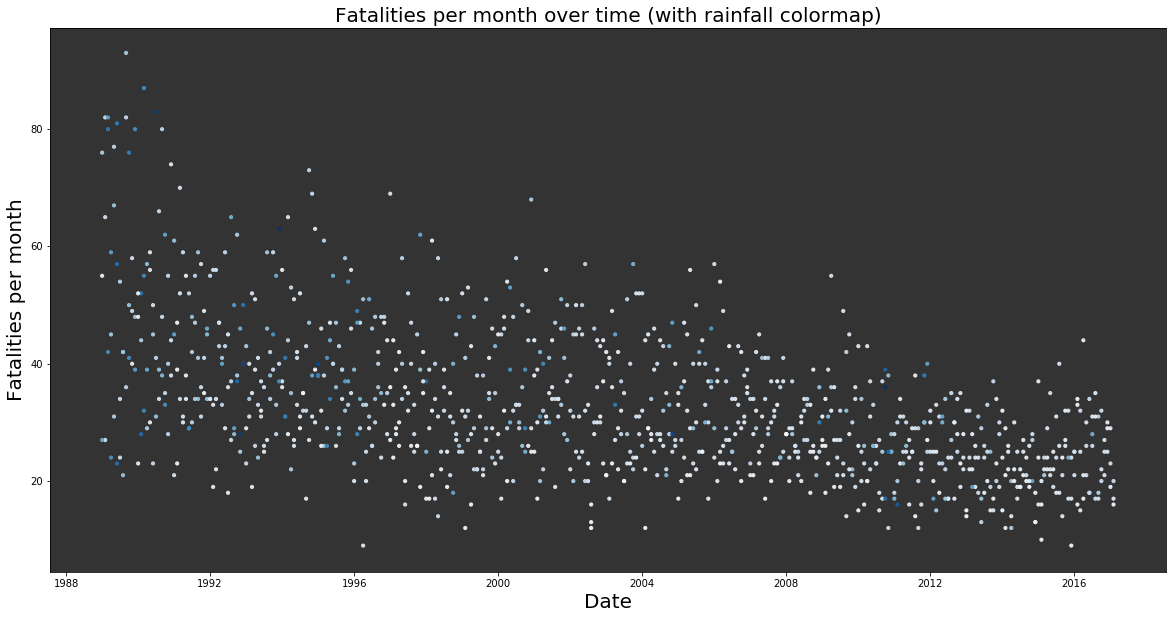

In [17]:
%matplotlib inline
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
conn = psycopg2.connect('dbname=info1903 user=lyneca')
cur = conn.cursor()

query = """
select rainfall, fatalities, rainfall.year, rainfall.month, rainfall.day                            
  from crashes, rainfall                                                
 where rainfall.year = crashes.year                                      
   and rainfall.month = extract(MONTH from to_date(concat(crashes.month, ' 2000'), 'Month YYYY'))                                                
   and rainfall.day = crashes.day
   and rainfall.rainfall is not null
   and crashes.fatalities is not null
   and crashes.state = 'STATE';
   """
states = [
    'NSW',
    'VIC',
    'QLD',
#     'WA',
#     'NT',
#     'SA',
#     'TAS',
]
fig, ax = plt.subplots(figsize=(20, 10))
c = 0.2
plt.title("Fatalities per month over time (with rainfall colormap)",fontsize=20)

ax.set_facecolor((c, c, c, 1))
fig.set_facecolor((1, 1, 1, 1))
queries = {x: query.replace("STATE", x) for x in states}
colors = iter('rgbcmyk')
maxs = []
mins = []
for q in queries:
    print(f"Processing {q}...")
    conn.rollback()
    cur.execute(queries[q])
    data = cur.fetchall()
    rounding = 1
    data = sorted([(round(x[0]/rounding)*rounding, x[1], datetime.datetime(x[2],x[3],1)) for x in data if (x[0] < 115 and x[1] < 10)], key=lambda x: (x[0],x[1]))
    rainfall = [x[0] for x in data]
    dates = list({x[2] for x in data})
    fatalities = [x[1] for x in data]
    maxs.append(max(rainfall))
    mins.append(min(rainfall))
    crashes = []
    rainfall = []
    for month in dates:
        crashes.append(sum([x[1] for x in data if x[2] == month]))
        rainfall.append(sum([x[0] for x in data if x[2] == month]))
    plt.scatter(dates, crashes, c=rainfall, label=q, alpha=0.9, s=10, cmap=plt.cm.get_cmap('Blues'))
    print(f"Done {q}.")
plt.xlabel("Date",fontsize=20)
plt.ylabel("Fatalities per month",fontsize=20)

# plt.legend()